# Denne seksjonen inneholder de første stegene som skal til for å bygge maskinlæringsmodellen

Vi flytter oss inn i TTT23Prosjekt-mappen på google drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/TTT23Prosjekt

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
[Errno 2] No such file or directory: '/gdrive/My Drive/TTT23Prosjekt'
/content


Laster ned en pakke vi trenger

In [ ]:
!pip install keras_cv

Her importerer vi mange vanlige biblioteker som trengs til å drive med maskinlæring. Iløpet av prosjektet har noen av bibliotekene blitt tatt i bruk og senere kanskje droppet. Vi lar bare import av bibliotekene stå for nå siden det går fint å importere noen ekstra.

In [ ]:
#Libraries
import PIL # image processing and visualization
import tensorflow as tf # the AI library
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import keras_cv
from keras import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")
tfk = tf.keras
tfkl = tf.keras.layers

Vi setter random seed så vi får akkurat samme resultater om vi kjører koden igjen på en ny pc.

In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Hjelpefunksjoner

Hjelpefunksjoner skrevet av Sondre som brukes til å lese inn bildene. Kun padde funksjonen brukes. Den legger til litt ekstra rom rundt bildene. Sånn at alle bildene får samme høyde og bredde om de ikke allerede har det.

In [ ]:

import cv2 as cv
import numpy as np
def paddImage(img, new_shape):
    """
    Cuts or pads the image with zeros to fit the shape new_shape

    img: np grayscale image
    new_shape: tuple with two values (height, width)

    return: an image with size new_shape
    """
    if img.shape[0] > new_shape[0]:
        img = img[:new_shape[0]]
    if img.shape[1] > new_shape[1]:
        img = img[:, :new_shape[1]]

    bottom = new_shape[0] - img.shape[0]
    right = new_shape[1] - img.shape[1]

    return cv.copyMakeBorder(img, 0, bottom, 0, right, cv.BORDER_CONSTANT)

def setGrayToBlack(img, threshold=150):
    """
    Sets the gray values of img to black.

    img: Needs to be a bgr numpy array
    threshold: value between 0-255, saturation values under this value gets set to black
    """

    h, s, v = cv.split(cv.cvtColor(img, cv.COLOR_BGR2HSV)) #Convert image to hsv
    gray_mask = s < threshold # Set a binary mask where saturation is under threshold
    v[gray_mask] = 0 # Set the value to 0 (set to black) where the mask is True
    out_image = cv.cvtColor(cv.merge((h, s, v)), cv.COLOR_HSV2BGR) #Convert back to bgr
    return out_image





Laster ned enda en pakke.

In [ ]:
pip install pymage_size

# Innhenting av bilder fra fil

Her har vi Sondres funksjon for å laste inn bilder. Den henter alle bildene inn i images og alle roi-vektorene [body nohead lung] inn i labels. Husk at X er bilder og Y er roi-verdier.

In [ ]:

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import csv
import cv2 as cv
import numpy as np
from pathlib import Path
import sys

from pymage_size import get_image_size

def readImages(csvPath):

    filenames = []
    roi = []
    max_shape = [0, 0]
    with open(csvPath) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
            else:
                path = Path.cwd() / row[0]
                filenames.append(str(path))
                img_size = get_image_size(str(path)).get_dimensions()[::-1]
                if img_size[0] > max_shape[0]:
                    max_shape[0] = img_size[0]
                if img_size[1] > max_shape[1]:
                    max_shape[1] = img_size[1]

                roi.append([float(row[1]), float(row[2]), float(row[3])])

    y = np.zeros((len(filenames), 3), float)
    images = np.zeros((len(filenames), max_shape[0], max_shape[1],3), dtype=np.uint8)
    for i, filepath in enumerate(filenames):
        img = cv.imread(str(filepath))

        img_pad = paddImage(img, max_shape)

        images[i] = img_pad
        y[i] = np.array(roi[i])

    return images, y

images, y = readImages(r"Rawdata_values.csv")
imagesClean = images
val_images = imagesClean[-5:]


imagesClean = imagesClean[:-5]


yClean = y  / (10**5) #Scale

val_labels = yClean[-5:]

yClean = yClean[:-5]



FileNotFoundError: ignored

Laster ned enda en pakke.

In [ ]:
pip install datasets

Laster inn Julie sine augmenterte bilder og legger de sammen med de originale som ikke er augmentert.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(imagesClean, yClean, test_size=0.2, random_state=42)
imagesAugJulie, yAugJulie = readImages(r"data.csv")
yAugJulie = yAugJulie / (10**5)


X_train = np.concatenate((X_train,imagesAugJulie)) #add all new augmented imgages from Julies augmenter to a new array.
y_train = np.concatenate((y_train,yAugJulie))

print(len(X_train))
print(len(y_train))

# Preprosessering av bildene for å kunne putte de inn i VGG16

Det som skjer her er at vi gjør dataene klare først for preprosesseringsfunksjonen "preprocess_input" og der sentreres alle bildene rundt 0 og så byttes fargekoding fra RGB til BGR. Vi deler også bildene i trening og test på std deviation så de er standardisert. Vi har også batching her. Vi sier at ett bilde går inn i CNNen av gangen. Da har vi en batch size lik 1.

In [ ]:
# Converting it to 'float32'
X_train = X_train.astype('float32')

# Convert the Numpy array to a TensorFlow tensor
X_train = tf.convert_to_tensor(X_train)


# Converting it to 'float32'
X_test = X_test.astype('float32')

# Convert the Numpy array to a TensorFlow tensor
X_test = tf.convert_to_tensor(X_test)



X_train = tf.keras.applications.vgg16.preprocess_input(X_train) / np.std(X_train)
X_test = tf.keras.applications.vgg16.preprocess_input(X_test) / np.std(X_test)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.batch(1)
test_dataset = test_dataset.batch(1)




# Lager VGG16-modellen her.

Her setter vi opp earlystopping med checkpoints. Sånn at når vi forbedrer modellen vår under trening  så lagres vektene og når vi ikke forbedrer modellen vår under trening så lagres ikke de vektene men vi beholder de gamle i checkpointet. Vi sier også at hva som vurderes som beste modell er den som har lavest "loss" på testdataene. Vi har en patience på 10 som betyr at om den ikke forbedres etter 10 nye treningsepoker så gir vi oss med treningen og bruker forrige checkpoint som vår beste modell. De er lagret allerede i filen vi spesifiserte her inne i TTT23Prosjekt-mappen på google drive.

In [ ]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best_Test1.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping, patience is set to 10 to make sure the model can improve with such a high dropout rate.
#The earlystopping is here based on finding the minimum validation loss.
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

Her lager vi en instans av VGG16. Vi definerer at vi skal fine-tune de 3 siste  layerene av nettverket. Fine-tuning betyr at vi trener kun de layersene vi spesifisierer (dvs de 3 siste i nettverket her), mens alle de andre trenes ikke.
De andre layersene får vekter fra trening gjort på datasettet "imagenet". Så vi har nå 3 layers som vi skal trene til å få nye vekter og så har vi mange andre som vi ikke rører som har vekter fra før gjennom trening på imagenet. Dette kalles for **transfer learning**. Vi overfører noe av den læringen andre har stått for men så må vi fine tune litt for vårt datasett og vår bruk. Dere kjørte på 3 layers fordi det ga best resultat. Trener man for mange layers blir det veldig computationally demanding (krever mye datakraft) og det kan hende det blir dårlig presisjon på modellen siden datasettet er så lite. Tar man derimot og trener for få layers så kan det hende nettverket ikke klarer å lære noe særlig av datasettet og ikke blir noe bedre enn om du bare hentet inn alle vektene dine fra imagenet.

I tillegg lager vi en hjemmelaget ende på VGG16 som består noen ulike komponenter. I denne hjemmelagde enden er et flatten layer som tar 2D arrays og gjør om til 1D arrays. Så matrisen blir da flat - ergo flatten. Videre har vi et dropout layer så det skrur av 40% av koblingene mot det forrige layeret randomly per bilde sånn at vi ikke overfitter. I tillegg har vi to dense layers. Det ene er stort for å ta inn all informasjon beregnet fra nettverket. Et dense layer er bare et flatt layer som inneholder N antall noder som gjør en matematisk operasjon på dataene våre. Så det er bare en propagering av masse info fra CNN'en kort sagt. Deretter har vi et siste dense layer som har 3 outputs. En for hver ROI verdi. Da kan CNNen outputte en prediction for hver enkelt ROI-verdi.

Videre i denne kodeblokken bestemmer vi at vi starter med en viss learning rate - hvor fort nettverket skal lære nye ting fra bildene. Vi definerer også at den skal eksponensielt falle nedover ettersom treningen foregår.

Vi har også bestemt at vi bruker en optimizer kalt Adam. Det er ikke så farlig å forstå hvordan den funker, men den gjør læringen enda bedre.

Helt til slutt sier vi at vi har loss function mean square error. Det er altså dette som nettverket bruker til å finne ut hvor bra den gjør det når den trener, og det er det vi bruker til å finne ut om vi skal gi oss med treningen når ting ikke går fremover. Vi har også lagt inn at vi ønsker å følge med på mean absolute error mellom predicted roi-verdier og de faktiske test-roi-verdiene

In [ ]:

fine_tune = 3
conv_base = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=(357, 229, 3))
 # The fine_tune param determines how many layers will be freezed from bottom and up
if fine_tune > 0:
  for layer in conv_base.layers[:-fine_tune]:
    layer.trainable = False
else:
  for layer in conv_base.layers:
    layer.trainable = False

# Create a new 'top' of the model (i.e. fully-connected layers) for the classification after feature extraction.
# This is 'bootstrapping' a new top_model onto the pretrained layers.
top_model = conv_base.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dropout(0.4)(top_model)
top_model = Dense(4096, activation='relu')(top_model)
output_layer = Dense(3, activation='relu')(top_model)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00007,
    decay_steps=100000,
    decay_rate=0.00003)


optim_1 = Adam(lr_schedule)

# Group the convolutional base and new fully-connected layers into a Model object.
model = Model(inputs=conv_base.input, outputs=output_layer)
model.compile(optimizer = optim_1, loss = tf.keras.losses.MeanSquaredError(), metrics=['mean_absolute_error'])
model.summary( )

vgg_epochs = 200




# Innlasting av vektene i VGG16 fra fil om man ønsker det

Hvis du ønsker kan du kjøre denne. Da laster du inn vektene fra fil fremfor å trene.

In [ ]:
# Loads the weights
model.load_weights('tl_model_v1.weights.best-3.hdf5')

Preprosessering av validationsettet så de kan kjøres gjennom VGG16 på en god måte.

In [ ]:
# Converting it to 'float32'
val_images = val_images.astype('float32')

val_images = tf.convert_to_tensor(val_images)

val_images = tf.keras.applications.vgg16.preprocess_input(val_images) / np.std(val_images)


Her predicter vi ved å sende alle 5 bildene i valideringssettet vårt gjennom modellen. Så sammenligner vi de med de faktiske roi-verdiene.

In [ ]:

predsOnVal = model.predict(val_images)
print(predsOnVal)
print(val_labels)



Vi regner den totale RMSE på alle de 5 predictionsene totalt.

In [ ]:
#RMSE
print(np.sqrt(np.mean((np.array(val_labels)-np.array(predsOnVal))**2)))

Vi regner den totale MSE på alle de 5 predictionsene totalt.

In [ ]:
#MSE
print(np.mean((np.array(val_labels)-np.array(predsOnVal))**2))

In [ ]:
#MAE
print(np.mean(np.abs(np.array(val_labels) - np.array(predsOnVal))))

---
**Stopp her**

---



# Trening av nettverket om man heller vil det

Vi trener her. Vi kjører model.fit på treningsdataene i et visst antall epoker. (dvs alle treningsdataene går gjennom nettverket i en epoke) Videre sier vi hva som er vårt testset og at vi har earlystopping med checkpoints i callbacks-parameteren. Vi har også verbose 1 fordi da skrives progress ut her så vi kan lese hvordan det går. I tillegg har vi .history for da lagrer vi historien i en variabel.

In [ ]:

#Fit the model with all the defined parameters and on the augmented dataset.
vgg_history_transfer = model.fit(train_dataset,
                            #batch_size=1,
                            epochs=vgg_epochs,
                            validation_data=test_dataset,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1).history

Epoch 1/200
71/71 [==============================] - ETA: 0s - loss: 1116.3671 - mean_absolute_error: 14.0260
Epoch 1: val_loss improved from inf to 6065.78711, saving model to tl_model_v1.weights.best_Test1.hdf5
71/71 [==============================] - 368s 5s/step - loss: 1116.3671 - mean_absolute_error: 14.0260 - val_loss: 6065.7871 - val_mean_absolute_error: 36.5706
Epoch 2/200
71/71 [==============================] - ETA: 0s - loss: 788.1993 - mean_absolute_error: 11.6667
Epoch 2: val_loss improved from 6065.78711 to 3850.39062, saving model to tl_model_v1.weights.best_Test1.hdf5
71/71 [==============================] - 329s 5s/step - loss: 788.1993 - mean_absolute_error: 11.6667 - val_loss: 3850.3906 - val_mean_absolute_error: 29.7476
Epoch 3/200
71/71 [==============================] - ETA: 0s - loss: 429.2563 - mean_absolute_error: 11.7417
Epoch 3: val_loss improved from 3850.39062 to 3329.53174, saving model to tl_model_v1.weights.best_Test1.hdf5
71/71 [=======================

Om du kjører denne snutten så lagrer du modellen med alle vektene. Du trenger ikke kjøre denne om du har lagret vektene dine gjennom earlystopping.

In [ ]:
model.save("content/savedmodels/vggFinetuned3_standardized") #Save the model for use on the test set.

Plotting av loss om du ønsker

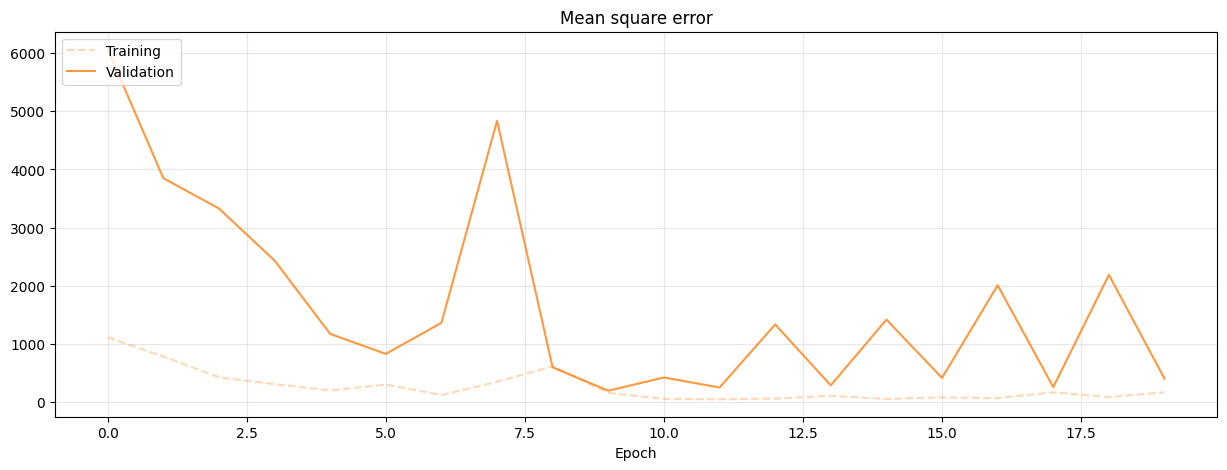

In [ ]:
#plots of the loss evolving for each epoch
plt.figure(figsize=(15,5))
plt.plot(vgg_history_transfer['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(vgg_history_transfer['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.title('Mean square error')
plt.grid(alpha=.3)


plt.show()

Dette er samme som før når vi hadde model.predict bare at i stad var det lagt høyere opp fordi vi loadet inn vektene fra en fil fremfor her hvor vi har trent modellen i colaben.

In [ ]:
# Converting it to 'float32'
val_images = val_images.astype('float32')

val_images = tf.convert_to_tensor(val_images)

val_images = tf.keras.applications.vgg16.preprocess_input(val_images) / np.std(val_images)

In [ ]:
predsOnVal = model.predict(val_images)
print(predsOnVal)
print(val_labels)

1/1 [==============================] - 13s 13s/step
[[31.426466  23.016878   7.794613 ]
 [18.291819   8.720162   1.8866491]
 [23.36303    6.3693595  2.0912695]
 [26.260836  11.576278   4.257177 ]
 [53.48144   22.45726   13.327297 ]]
[[25.03  20.05   6.308]
 [15.85   7.269  3.223]
 [19.91   4.986  1.576]
 [23.85   9.776  2.595]
 [20.75  10.2    2.225]]


In [ ]:
#RMSE
print(np.sqrt(np.mean((np.array(val_labels)-np.array(predsOnVal))**2)))

9.772575900201677


In [ ]:
#MSE
print(np.mean((np.array(val_labels)-np.array(predsOnVal))**2))

95.5032397252026
